In [1]:
!pip install torch torchvision einops==0.3.2 tqdm==4.64.1 numpy==1.23.5 scikit-image==0.19.3 lpips==0.1.4 pyyaml==6.0 Pillow==9.4.0 matplotlib==3.6.2 opencv-python==4.6.0.66


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.3/57.3 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.9/13.9 MB 59.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 682.2/682.2 kB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 84.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.7 MB/s eta 0:00:00
  Attempting uninstall: einops
    Found existing installation: einops 0.8.0
    Uninstalling einops-0.8.0:
      Successfully uninstalled einops-0.8.0
  Attempting uninstall: tqdm
    Found existing installation:

## Instructions to Access and Use the Datasets

### Step 1: Connect Google Drive to Colab
Run the following code in a Colab cell to mount your Google Drive:
```python
from google.colab import drive
drive.mount('/content/drive')
```
### Step 2: Add Shortcuts to Your Google Drive

Open the provided dataset links:
ISTD+ Dataset: https://drive.google.com/drive/folders/1C2KMeXL4k5gKBaulv6eUIDkuUMY1FVaN?usp=drive_link


SRD Dataset : https://drive.google.com/drive/folders/1Y-BDpgtCh5tjKWfrQClcdPfMveO5NcKe?usp=drive_link


On the Google Drive interface:
Click the left-hand menu (three vertical dots or options menu).
Select "Organize" or "Add shortcut to Drive".
Choose a folder in your Google Drive where you want to save the shortcut and confirm.

### Step 3: Access the Datasets in Colab
After adding the shortcuts, navigate to the mounted drive in Colab

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.models as models
from torchvision.utils import save_image
from einops import rearrange
from PIL import Image
import os
import math
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# Constants
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


from torchvision import transforms
import torchvision.transforms.functional as TF
import random

class ShadowRemovalDataset(Dataset):
    def __init__(self, gt_dir, lq_dir, transform=None, augment=False):
        self.gt_dir = gt_dir
        self.lq_dir = lq_dir
        self.transform = transform
        self.augment = augment
        self.gt_images = sorted(os.listdir(gt_dir))
        self.lq_images = sorted(os.listdir(lq_dir))

    def __len__(self):
        return len(self.gt_images)

    def augment_images(self, gt_image, lq_image):
        # Random rotation
        angle = random.choice([0, 90, 180, 270])
        gt_image = TF.rotate(gt_image, angle)
        lq_image = TF.rotate(lq_image, angle)

        # Random horizontal flipping
        if random.random() > 0.25:
            gt_image = TF.hflip(gt_image)
            lq_image = TF.hflip(lq_image)

        # Random vertical flipping
        if random.random() > 0.25:
            gt_image = TF.vflip(gt_image)
            lq_image = TF.vflip(lq_image)

        return gt_image, lq_image

    def random_crop(self, gt_image, lq_image):
        i, j, h, w = transforms.RandomCrop.get_params(
            gt_image, output_size=(256, 256))
        gt_image = TF.crop(gt_image, i, j, h, w)
        lq_image = TF.crop(lq_image, i, j, h, w)
        return gt_image, lq_image

    def __getitem__(self, idx):
        gt_img_path = os.path.join(self.gt_dir, self.gt_images[idx])
        lq_img_path = os.path.join(self.lq_dir, self.lq_images[idx])

        gt_image = Image.open(gt_img_path).convert("RGB")
        lq_image = Image.open(lq_img_path).convert("RGB")

        if self.augment:
            #pass
            gt_image, lq_image = self.augment_images(gt_image, lq_image)
            gt_image, lq_image = self.random_crop(gt_image, lq_image)

        if self.transform:
            gt_image = self.transform(gt_image)
            lq_image = self.transform(lq_image)

        return lq_image, gt_image


In [8]:

import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleGate(nn.Module):
    def forward(self, x):
        x1, x2 = x.chunk(2, dim=-1)
        return x1 * x2

class ASPP(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.conv2 = nn.Conv2d(in_channels, out_channels, 3, padding=6, dilation=6, bias=False)
        self.conv3 = nn.Conv2d(in_channels, out_channels, 3, padding=12, dilation=12, bias=False)
        self.conv4 = nn.Conv2d(in_channels, out_channels, 3, padding=18, dilation=18, bias=False)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.conv5 = nn.Conv2d(in_channels, out_channels, 1, bias=False)
        self.conv_out = nn.Conv2d(out_channels * 5, out_channels, 1, bias=False)
        self.norm = nn.LayerNorm(out_channels)
        self.act = nn.SiLU()

    def forward(self, x):
        size = x.shape[-2:]
        feat1 = self.conv1(x)
        feat2 = self.conv2(x)
        feat3 = self.conv3(x)
        feat4 = self.conv4(x)
        feat5 = torch.nn.functional.interpolate(self.conv5(self.pool(x)), size=size, mode='bilinear', align_corners=False)
        out = torch.cat((feat1, feat2, feat3, feat4, feat5), dim=1)
        out = self.conv_out(out)
        out = out.permute(0, 2, 3, 1)  # Change to (B, H, W, C)
        out = self.norm(out)
        out = out.permute(0, 3, 1, 2)  # Change back to (B, C, H, W)
        return self.act(out)

class CWSA(nn.Module):
    def __init__(self, dim):
        super(CWSA, self).__init__()
        self.dim = dim
        self.query_conv = nn.Linear(dim, dim)
        self.key_conv = nn.Linear(dim, dim)
        self.value_conv = nn.Linear(dim, dim)
        self.scale = dim ** -0.5
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, 1, dim))

    def forward(self, x):
        # x: (B, H, W, C)
        B, H, W, C = x.shape
        x = x + self.pos_embedding  # Positional embedding
        x = x.view(B, H * W, C)     # Reshape to (B, N, C)

        # Linear projections
        q = self.query_conv(x)      # (B, N, C)
        k = self.key_conv(x)        # (B, N, C)
        v = self.value_conv(x)      # (B, N, C)

        # Compute attention over channels at each spatial location
        q = q.view(B, H * W, 1, C)  # (B, N, 1, C)
        k = k.view(B, H * W, C, 1)  # (B, N, C, 1)
        attn = torch.matmul(q, k).squeeze(2) * self.scale  # (B, N, C)
        attn = attn.softmax(dim=-1)  # Softmax over channels

        # Apply attention to values
        out = attn * v               # Element-wise multiplication
        out = out.view(B, H, W, C)   # Reshape back to (B, H, W, C)
        return out

class SSVAModule(nn.Module):
    def __init__(self, d_model, d_state=16, d_conv=3, expand=2.0, dt_rank=64, dt_min=0.001, dt_max=0.1, dt_init="random", dt_scale=1.0):
        super().__init__()
        self.d_model = d_model
        self.d_state = d_state
        self.d_conv = d_conv
        self.expand = expand
        self.d_inner = int(self.expand * self.d_model)  # self.d_inner = 2 * d_model
        self.dt_rank = dt_rank

        self.in_proj = nn.Linear(self.d_model, self.d_inner * 2)
        self.conv2d = nn.Conv2d(self.d_inner, self.d_inner, kernel_size=d_conv, padding=(d_conv - 1) // 2, groups=self.d_inner)
        self.act = nn.SiLU()

        self.x_proj = nn.Linear(self.d_inner, self.d_inner * 2)
        self.dt_proj = nn.Linear(self.d_inner, self.d_inner)

        self.out_norm = nn.LayerNorm(self.d_inner)

        self.out_proj = nn.Linear(self.d_inner // 2, d_model)

        # New components
        self.simple_gate = SimpleGate()
        self.aspp = ASPP(d_model, d_model)
        self.channel_attn = CWSA(d_model)

    def forward(self, x):
        B, H, W, C = x.shape

        # Apply ASPP
        x_aspp = self.aspp(x.permute(0, 3, 1, 2)).permute(0, 2, 3, 1)

        # Original SS2D operations
        x = self.in_proj(x)
        x, z = x.chunk(2, dim=-1)
        x = x.permute(0, 3, 1, 2)
        x = self.conv2d(x)
        x = x.permute(0, 2, 3, 1)
        x = self.act(x)
        y = self.selective_scan(x)
        y = self.out_norm(y)
        y = y * F.silu(z)

        # Apply SimpleGate
        y = self.simple_gate(y)

        # Apply Channel-wise Self-Attention
        y = self.channel_attn(y)

        # Combine with ASPP output
        y = y + x_aspp

        out = self.out_proj(y)
        return out

    def selective_scan(self, x):
        B, H, W, C = x.shape
        x_flat = x.reshape(B, H * W, C)
        x_dbl = self.x_proj(x_flat)
        x_dbl = x_dbl.view(B, H, W, -1)
        dt, x_proj = x_dbl.chunk(2, dim=-1)
        dt = F.softplus(self.dt_proj(dt))
        y = x * torch.sigmoid(dt) + x_proj * torch.tanh(x_proj)
        return y

class SSVABlock(nn.Module):
    def __init__(self, d_model, d_state=16):
        super().__init__()
        self.ln_1 = nn.LayerNorm(d_model)
        self.ss2d = SSVAModule(d_model, d_state)
        self.ln_2 = nn.LayerNorm(d_model)
        self.conv_blk = nn.Sequential(
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(d_model, d_model, kernel_size=3, padding=1)
        )

    def forward(self, x):
        residual = x
        x = self.ln_1(x)
        x = residual + self.ss2d(x)
        residual = x
        x = self.ln_2(x)
        x = x.permute(0, 3, 1, 2)
        x = self.conv_blk(x)
        x = x.permute(0, 2, 3, 1)
        x = residual + x
        return x

class SSVA_Net(nn.Module):
    def __init__(self, img_channel=3, width=32, middle_blk_num=1, enc_blk_nums=[1, 1, 1, 1], dec_blk_nums=[1, 1, 1, 1], d_state=64):
        super().__init__()
        self.intro = nn.Conv2d(img_channel, width, kernel_size=3, padding=1, stride=1, groups=1, bias=True)
        self.ending = nn.Conv2d(width, img_channel, kernel_size=3, padding=1, stride=1, groups=1, bias=True)

        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        self.middle_blks = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()

        chan = width
        for num in enc_blk_nums:
            self.encoders.append(
                nn.Sequential(*[SSVABlock(chan, d_state) for _ in range(num)])
            )
            self.downs.append(nn.Conv2d(chan, 2 * chan, 2, 2))
            chan = chan * 2

        self.middle_blks = nn.Sequential(
            *[SSVABlock(chan, d_state) for _ in range(middle_blk_num)]
        )

        for num in dec_blk_nums:
            self.ups.append(nn.Sequential(
                nn.Conv2d(chan, chan * 2, 1, bias=False),
                nn.PixelShuffle(2)
            ))
            chan = chan // 2
            self.decoders.append(
                nn.Sequential(*[SSVABlock(chan, d_state) for _ in range(num)])
            )

        self.padder_size = 2 ** len(self.encoders)

    def forward(self, inp):
        B, C, H, W = inp.shape
        inp = self.check_image_size(inp)
        x = self.intro(inp)
        x = x.permute(0, 2, 3, 1)

        encs = []
        for encoder, down in zip(self.encoders, self.downs):
            x = encoder(x)
            encs.append(x)
            x = x.permute(0, 3, 1, 2)
            x = down(x)
            x = x.permute(0, 2, 3, 1)

        x = self.middle_blks(x)

        for decoder, up, enc_skip in zip(self.decoders, self.ups, encs[::-1]):
            x = x.permute(0, 3, 1, 2)
            x = up(x)
            x = x.permute(0, 2, 3, 1)
            x = x + enc_skip
            x = decoder(x)

        x = x.permute(0, 3, 1, 2)
        x = self.ending(x)
        x = x + inp

        return x[:, :, :H, :W]

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.padder_size - h % self.padder_size) % self.padder_size
        mod_pad_w = (self.padder_size - w % self.padder_size) % self.padder_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h))
        return x


In [9]:

# Loss functions (unchanged)
class VGGLoss(nn.Module):
    def __init__(self, device=DEVICE):
        super(VGGLoss, self).__init__()
        vgg = models.vgg19(pretrained=True).features.to(device).eval()
        self.vgg_layers = nn.Sequential(*list(vgg)[:36]).to(device)
        self.device = device
        for param in self.vgg_layers.parameters():
            param.requires_grad = False

    def forward(self, x, y):
        x = x.to(self.device)
        y = y.to(self.device)
        x_vgg = self.vgg_layers(x)
        y_vgg = self.vgg_layers(y)
        return nn.functional.l1_loss(x_vgg, y_vgg)

class FocalFrequencyLoss(nn.Module):
    def __init__(self, alpha=1.0, device=DEVICE):
        super(FocalFrequencyLoss, self).__init__()
        self.alpha = alpha
        self.device = device

    def forward(self, input, target):
        input = input.to(self.device)
        target = target.to(self.device)
        input_fft = torch.fft.fft2(input)
        target_fft = torch.fft.fft2(target)
        diff = input_fft - target_fft
        abs_diff = torch.abs(diff)
        loss = torch.pow(abs_diff, self.alpha)
        return torch.mean(loss)

class CombinedLoss(nn.Module):
    def __init__(self, lambda_vgg=0.01, lambda_ff=0.1, device=DEVICE):
        super(CombinedLoss, self).__init__()
        self.lambda_vgg = lambda_vgg
        self.lambda_ff = lambda_ff
        self.l1_loss = nn.L1Loss()
        self.vgg_loss = VGGLoss(device=device)
        self.ff_loss = FocalFrequencyLoss(device=device)

    def forward(self, input, target):
        l1 = self.l1_loss(input, target)
        vgg = self.vgg_loss(input, target)
        ff = self.ff_loss(input, target)
        return l1 + self.lambda_vgg * vgg + self.lambda_ff * ff

class VGG_comLoss(nn.Module):
    def __init__(self, lambda_vgg=0.01, lambda_ff=0.1, device=DEVICE):
        super(VGG_comLoss, self).__init__()
        self.lambda_vgg = lambda_vgg
        self.lambda_ff = lambda_ff
        self.l1_loss = nn.L1Loss()
        self.vgg_loss = VGGLoss(device=device)
        self.ff_loss = FocalFrequencyLoss(device=device)

    def forward(self, input, target):
        l1 = self.l1_loss(input, target)
        vgg = self.vgg_loss(input, target)
        ff = self.ff_loss(input, target)
        return l1 + self.lambda_vgg * vgg

class CharbonnierLoss(nn.Module):
    """Charbonnier Loss (L1)"""

    def __init__(self, eps=1e-3):
        super(CharbonnierLoss, self).__init__()
        self.eps = eps

    def forward(self, x, y):
        diff = x - y
        # loss = torch.sum(torch.sqrt(diff * diff + self.eps))
        loss = torch.mean(torch.sqrt((diff * diff) + (self.eps*self.eps)))
        return loss
# l1_loss = nn.L1Loss()
# Training and validation functions (unchanged)



def train(model, train_loader, val_loader, num_epochs, device, save_dir, LEARNING_RATE):
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-8)
    criterion = VGG_comLoss(device= device)

    # Initialize lists to store metrics
    training_losses = []
    validation_losses = []
    psnr_list = []
    ssim_list = []
    lpips_list = []
    psnr_basicsr_list = []
    ssim_basicsr_list = []

    # Initialize best PSNR
    best_psnr = 0.0
    # best_lpips = 100.0

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        with tqdm(total=len(train_loader), desc=f'Epoch {epoch + 1}/{NUM_EPOCHS}', unit='batch') as pbar:
            for real_shadow, real_free in train_loader:
                real_shadow, real_free = real_shadow.to(device), real_free.to(device)

                optimizer.zero_grad()
                pred_free = model(real_shadow)
                loss = criterion(pred_free, real_free)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                optimizer.step()

                total_loss += loss.item()
                pbar.set_postfix(loss=loss.item())
                pbar.update(1)

        avg_loss = total_loss / len(train_loader)
        training_losses.append(avg_loss)
        print(f"Epoch [{epoch + 1}/{NUM_EPOCHS}] - Average Loss: {avg_loss:.4f}")
        scheduler.step()

        # Validate every epoch
        avg_val_loss, avg_psnr, avg_ssim, avg_lpips, avg_psnr_basicsr, avg_ssim_basicsr = validate_and_save(
            model, val_loader, criterion, device, epoch, save_dir, num_epochs
        )

        validation_losses.append(avg_val_loss)
        psnr_list.append(avg_psnr)
        ssim_list.append(avg_ssim)
        lpips_list.append(avg_lpips)
        psnr_basicsr_list.append(avg_psnr_basicsr)
        ssim_basicsr_list.append(avg_ssim_basicsr)

        # Check if current avg_psnr is better than best_psnr
        if avg_psnr > best_psnr:
        # if avg_lpips < best_lpips:
            best_psnr = avg_psnr
            # best_lpips = avg_lpips
            # Save model checkpoint
            checkpoint_dir = os.path.join(save_dir, 'best_checkpoints')
            os.makedirs(checkpoint_dir, exist_ok=True)
            checkpoint_path = os.path.join(checkpoint_dir, f'shadow_removal_best.pth')
            torch.save(model.state_dict(), checkpoint_path)
            print(f"New best PSNR: {best_psnr:.4f}. Model saved to {checkpoint_path}")
        else:
            print(f"PSNR did not improve from {best_psnr:.4f}")


    # After training, save metrics to CSV
    import pandas as pd
    metrics_data = {
        'Epoch': list(range(1, num_epochs + 1)),
        'Training Loss': training_losses,
        'Validation Loss': validation_losses,
        'PSNR': psnr_list,
        'SSIM': ssim_list,
        'LPIPS': lpips_list,
        'PSNR Basicsr': psnr_basicsr_list,
        'SSIM Basicsr': ssim_basicsr_list
    }
    metrics_df = pd.DataFrame(metrics_data)
    csv_path = os.path.join(save_dir, 'training_metrics.csv')
    metrics_df.to_csv(csv_path, index=False)
    print(f"Metrics saved to {csv_path}")

    # Plot the curves
    import matplotlib.pyplot as plt

    # Plot Training and Validation Loss
    plt.figure()
    plt.plot(metrics_df['Epoch'], metrics_df['Training Loss'], label='Training Loss')
    plt.plot(metrics_df['Epoch'], metrics_df['Validation Loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'loss_curve.png'))
    plt.close()

    # Plot PSNR
    plt.figure()
    plt.plot(metrics_df['Epoch'], metrics_df['PSNR'], label='PSNR (RGB)')
    plt.plot(metrics_df['Epoch'], metrics_df['PSNR Basicsr'], label='PSNR Basicsr (Y channel)')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'psnr_curve.png'))
    plt.close()

    # Plot SSIM
    plt.figure()
    plt.plot(metrics_df['Epoch'], metrics_df['SSIM'], label='SSIM (RGB)')
    plt.plot(metrics_df['Epoch'], metrics_df['SSIM Basicsr'], label='SSIM Basicsr (Y channel)')
    plt.xlabel('Epoch')
    plt.ylabel('SSIM')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'ssim_curve.png'))
    plt.close()

    # Plot LPIPS
    plt.figure()
    plt.plot(metrics_df['Epoch'], metrics_df['LPIPS'], label='LPIPS')
    plt.xlabel('Epoch')
    plt.ylabel('LPIPS')
    plt.legend()
    plt.savefig(os.path.join(save_dir, 'lpips_curve.png'))
    plt.close()

    print("Training completed")


####################################################
# Validation
# %cd /data/Image_restoration/shadow_removal_cvpr_2025/my_model/window/BasicSR
import lpips
import torch
import os
import torch.nn.functional as F
# from basicsr.metrics.psnr_ssim import calculate_psnr_pt, calculate_ssim_pt
# from basicsr.utils import img2tensor
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
from torchvision.utils import save_image

def validate_and_save(model, val_loader, criterion, device, epoch, save_dir, num_epochs):
    model.eval()
    total_psnr = 0
    total_ssim = 0
    total_psnr_basicsr = 0
    total_ssim_basicsr = 0
    total_lpips = 0
    val_loss = 0
    total_num_images = 0  # Keep track of total images processed

    # Initialize LPIPS model
    lpips_model = lpips.LPIPS(net='alex').to(device)

    # Create a separate folder for checkpoints
    checkpoint_dir = os.path.join(save_dir, 'checkpoints')
    os.makedirs(checkpoint_dir, exist_ok=True)
    sample_images_dir = os.path.join(save_dir, 'sample_images')
    os.makedirs(sample_images_dir, exist_ok=True)

    with torch.no_grad():
        for i, (real_shadow, real_free) in enumerate(val_loader):
            real_shadow, real_free = real_shadow.to(device), real_free.to(device)
            pred_free = model(real_shadow)

            loss = criterion(pred_free, real_free)
            val_loss += loss.item()

            batch_size = real_free.size(0)
            total_num_images += batch_size

            # Calculate PSNR and SSIM using original method (on RGB images)
            pred_free_np = pred_free.cpu().numpy().transpose(0, 2, 3, 1)
            real_free_np = real_free.cpu().numpy().transpose(0, 2, 3, 1)

            for j in range(batch_size):
                # Original PSNR and SSIM (RGB images)
                psnr_value = psnr(real_free_np[j], pred_free_np[j], data_range=1)
                ssim_value = ssim(real_free_np[j], pred_free_np[j], data_range=1, channel_axis=-1)
                total_psnr += psnr_value
                total_ssim += ssim_value

            # Calculate PSNR and SSIM using basicsr (on tensors)
            psnr_basicsr = calculate_psnr_pt(pred_free, real_free, crop_border=4, test_y_channel=True)
            ssim_basicsr = calculate_ssim_pt(pred_free, real_free, crop_border=4, test_y_channel=True)
            total_psnr_basicsr += psnr_basicsr.sum().item()
            total_ssim_basicsr += ssim_basicsr.sum().item()

            # Calculate LPIPS
            lpips_score = lpips_model(pred_free, real_free)
            total_lpips += lpips_score.sum().item()

            # Save some sample images
            if i == 0:
                save_image(pred_free, os.path.join(sample_images_dir, f'pred_free_epoch_{epoch + 1}.png'))
                save_image(real_shadow, os.path.join(sample_images_dir, f'real_shadow_epoch_{epoch + 1}.png'))
                save_image(real_free, os.path.join(sample_images_dir, f'real_free_epoch_{epoch + 1}.png'))

    avg_psnr = total_psnr / total_num_images
    avg_ssim = total_ssim / total_num_images
    avg_psnr_basicsr = total_psnr_basicsr / total_num_images
    avg_ssim_basicsr = total_ssim_basicsr / total_num_images
    avg_lpips = total_lpips / total_num_images
    avg_loss = val_loss / len(val_loader)

    print(f"Validation after Epoch [{epoch + 1}/{num_epochs}]")
    print(f"Avg Loss: {avg_loss:.4f}")
    print(f"Original PSNR (RGB): {avg_psnr:.4f}, Original SSIM (RGB): {avg_ssim:.4f}")
    print(f"Basicsr PSNR (Y channel, crop=4): {avg_psnr_basicsr:.4f}, Basicsr SSIM (Y channel, crop=4): {avg_ssim_basicsr:.4f}")
    print(f"Avg LPIPS: {avg_lpips:.4f}")

    # Save model checkpoint in the separate folder
    #checkpoint_path = os.path.join(checkpoint_dir, f'shadow_removal_epoch_{epoch + 1}.pth')
    #torch.save(model.state_dict(), checkpoint_path)
    #print(f"Checkpoint saved to {checkpoint_path}")

    return avg_loss, avg_psnr, avg_ssim, avg_lpips, avg_psnr_basicsr, avg_ssim_basicsr

# Training

In [ ]:
# Main execution
if __name__ == "__main__":
    # Define directories
    LEARNING_RATE = 0.0002
    NUM_EPOCHS = 32
    BATCH_SIZE = 128
    SAVE_INTERVAL = 10
    train_gt_dir = '/media/anas/Data/Anas_Work_2/shadow_removal/SBSR/train-20240919T062731Z-001/train/GT'
    train_lq_dir = '/media/anas/Data/Anas_Work_2/shadow_removal/SBSR/train-20240919T062731Z-001/train/LQ'
    val_gt_dir = '/media/anas/Data/Anas_Work_2/shadow_removal/SBSR/val/GT'
    val_lq_dir = '/media/anas/Data/Anas_Work_2/shadow_removal/SBSR/val/LQ'
    save_dir = os.getenv("SAVE_DIR", "/default/path/if/not/set")
    weights_path = '/data/Image_restoration/shadow_removal_cvpr_2025/test_differnet_loss/3_SBSR_MambaIR_old_Compined_loss/shadow_removal_epoch_59.pth'

    os.makedirs(save_dir, exist_ok=True)

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Adjust size as needed
        transforms.ToTensor(),
    ])

    # Create datasets and dataloaders
    train_dataset = ShadowRemovalDataset(train_gt_dir, train_lq_dir, transform=transform, augment=True)
    val_dataset = ShadowRemovalDataset(val_gt_dir, val_lq_dir, transform=transform, augment=False)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
    print("Data loaders created successfully")

    # Initialize model
    # Initialize model
    model = SSVA_Net(img_channel=3, width=32, middle_blk_num=1,
                             enc_blk_nums=[1, 1, 1, 1], dec_blk_nums=[1, 1, 1, 1],
                             d_state=64)  # Changed d_state to 64 to match dt_rank
    print("Model initialized")
    total_params = sum(p.numel() for p in model.parameters())
    print(f'Total number of parameters: {total_params}')
    #print(model)
    # Load weights if available
    #if os.path.exists(weights_path):
    #    model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
     #   print(f"Loaded model weights from {weights_path}")
    #else:
     #   print("No pre-trained weights found, training from scratch.")

    # Train the model
    train(model, train_loader, val_loader, NUM_EPOCHS, DEVICE, save_dir, LEARNING_RATE)

# Inference

In [10]:
import torch
from torchvision.transforms import ToTensor, ToPILImage
from PIL import Image
import os
from torchvision.utils import save_image

# Constants
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def load_model(model, weights_path):
    """
    Load the model weights.
    Args:
        model: Initialized model object.
        weights_path: Path to the pre-trained weights.
    Returns:
        model: Model with loaded weights.
    """
    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=DEVICE))
        print(f"Model weights loaded from {weights_path}")
    else:
        raise FileNotFoundError(f"Model weights not found at {weights_path}")
    return model

def preprocess_image(image_path, target_size=(512, 512)):
    """
    Preprocess the input image for the model.
    Args:
        image_path: Path to the input image.
        target_size: Tuple (H, W) for resizing.
    Returns:
        tensor: Preprocessed image tensor.
    """
    image = Image.open(image_path).convert("RGB")
    transform = transforms.Compose([
        transforms.Resize(target_size),
        ToTensor()
    ])
    tensor = transform(image).unsqueeze(0)  # Add batch dimension
    return tensor

def save_output_image(tensor, output_path):
    """
    Save the output tensor as an image.
    Args:
        tensor: Predicted image tensor.
        output_path: Path to save the output image.
    """
    image = ToPILImage()(tensor.squeeze(0).cpu())
    image.save(output_path)
    print(f"Output saved to {output_path}")

def inference(model, input_image_path, output_image_path, target_size=(512, 512)):
    """
    Run inference using the trained model.
    Args:
        model: Trained model.
        input_image_path: Path to the input image.
        output_image_path: Path to save the output image.
        target_size: Tuple (H, W) for resizing the input.
    """
    # Preprocess input image
    input_tensor = preprocess_image(input_image_path, target_size=target_size).to(DEVICE)

    # Perform inference
    model.eval()
    with torch.no_grad():
        output_tensor = model(input_tensor)

    # Save the output
    save_output_image(output_tensor, output_image_path)

# Main execution for inference
if __name__ == "__main__":
    # Define paths
    input_image_path = "/content/drive/MyDrive/Abalation_study_CVPR/shadow/SRD1.jpg"  # Replace with your input image path
    output_image_path = "/content/sample_data/shadow_free_image.png"  # Replace with your desired output path
    model_weights_path = "/content/drive/MyDrive/CVPR_2025/ISTD+/Weights/ISTD+_256.pth"  # Replace with your trained model weights

    # Initialize and load the model
    model = SSVA_Net(img_channel=3, width=32, middle_blk_num=1,
                                  enc_blk_nums=[1, 1, 1, 1], dec_blk_nums=[1, 1, 1, 1], d_state=64)
    model = load_model(model.to(DEVICE), model_weights_path)

    # Run inference
    inference(model, input_image_path, output_image_path, target_size=(512, 512))


<ipython-input-10-b46839868b79>:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(weights_path, map_location=DEVICE))


Model weights loaded from /content/drive/MyDrive/CVPR_2025/ISTD+/Weights/ISTD+_256.pth
Output saved to /content/sample_data/shadow_free_image.png


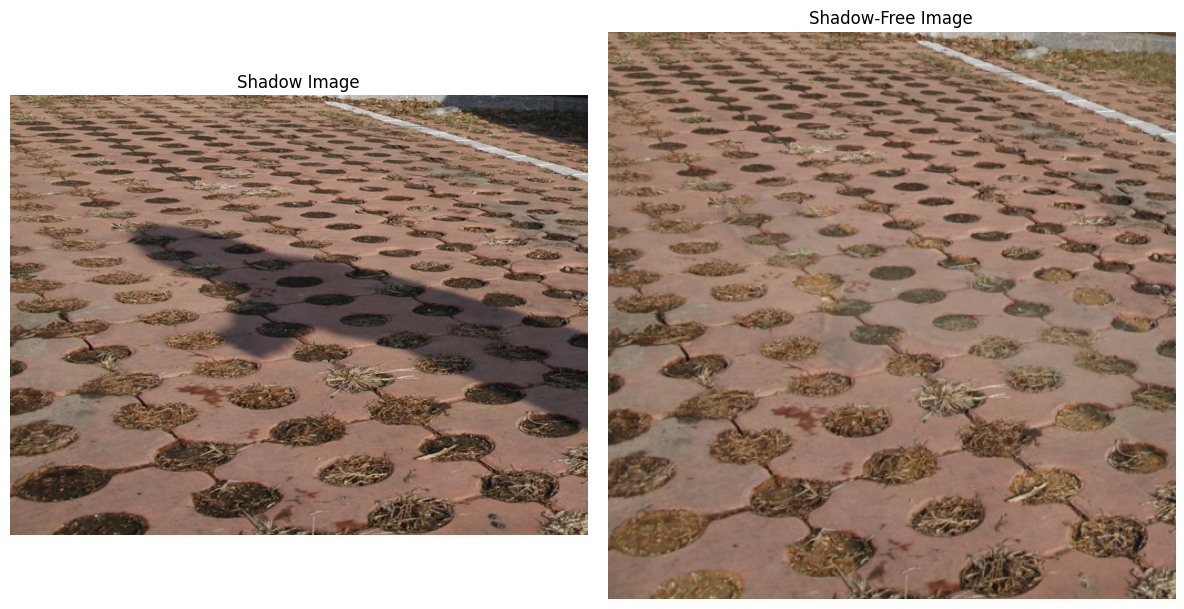

In [11]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage

def display_input_output(input_image_path, output_image_path):
    """
    Display the input shadow image and the output shadow-free image side by side.
    Args:
        input_image_path: Path to the input shadow image.
        output_image_path: Path to the output shadow-free image.
    """
    # Load images
    input_image = Image.open(input_image_path).convert("RGB")
    output_image = Image.open(output_image_path).convert("RGB")

    # Display images side by side
    plt.figure(figsize=(12, 6))

    # Display shadow image
    plt.subplot(1, 2, 1)
    plt.title("Shadow Image")
    plt.imshow(input_image)
    plt.axis("off")

    # Display shadow-free image
    plt.subplot(1, 2, 2)
    plt.title("Shadow-Free Image")
    plt.imshow(output_image)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Example usage
input_image_path = "/content/drive/MyDrive/Abalation_study_CVPR/shadow/SRD1.jpg"  # Replace with the same input image path used for inference
output_image_path = "/content/sample_data/shadow_free_image.png"  # Replace with the path where the output image was saved

display_input_output(input_image_path, output_image_path)


# Evaluation

In [6]:
import os
import lpips
import numpy as np
import torchvision
import torchvision.transforms.functional as F
from PIL import Image
from imageio.v2 import imread
import skimage
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import structural_similarity as compare_ssim
from skimage.color import rgb2lab
import scipy

loss_fn_vgg = lpips.LPIPS(net='vgg').cuda() # vgg is used in the paper

def load_item(gt_path, pre_path, mask_path):


    gt = imread(gt_path)
    try:
        pre = imread(pre_path)
    except:
        pre = imread(pre_path.replace('.JPG', '.png'))
    if mask_path is not None:
        mask = imread(mask_path)


    # resize to gt size
    pre = resize(pre, (gt.shape[0], gt.shape[1]))
    if mask_path is not None:
        mask = resize(mask, (gt.shape[0], gt.shape[1]))
        mask = (mask > 255 * 0.9).astype(np.uint8) * 255

    if mask_path is not None:
        return to_tensor(gt), to_tensor(pre), to_tensor(mask)
    else:
        return to_tensor(gt), to_tensor(pre), None


def to_tensor(img):
    img = Image.fromarray(img)
    img_t = F.to_tensor(img).float()
    img_t = img_t.unsqueeze(dim=0)
    return img_t


def resize(img, target_size):
    img = skimage.transform.resize(img, target_size, mode='reflect', anti_aliasing=True)
    img = (img * 255).astype(np.uint8)  # Ensure the image is in uint8 format

    return img

def calc_rmse(real_img, fake_img):
    # Convert to LAB color space
    real_lab = rgb2lab(real_img)
    fake_lab = rgb2lab(fake_img)
    rmse = np.sqrt(((real_lab - fake_lab) ** 2).mean())
    return rmse


def metric(gt, pre):
    transf = torchvision.transforms.Compose(
                [torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

    lpips_value = loss_fn_vgg(transf(pre[0]).cuda(), transf(gt[0]).cuda()).item()

    pre = pre * 255.0
    pre = pre.permute(0, 2, 3, 1)
    pre = pre.detach().cpu().numpy().astype(np.uint8)[0]

    gt = gt * 255.0
    gt = gt.permute(0, 2, 3, 1)
    gt = gt.cpu().detach().numpy().astype(np.uint8)[0]

    psnr = compare_psnr(gt, pre)
    ssim = compare_ssim(gt, pre, data_range=255, channel_axis=-1)
    rmse = calc_rmse(gt, pre)

    return psnr, ssim, lpips_value, rmse



def evaluation(gt_root, pre_root, mask_root):
    fnames = os.listdir(gt_root)
    fnames.sort()

    psnr_all_list, ssim_all_list, lpips_all_list, rmse_all_list = [], [], [], []
    psnr_non_list, ssim_non_list, lpips_non_list, rmse_non_list = [], [], [], []
    psnr_shadow_list, ssim_shadow_list, lpips_shadow_list, rmse_shadow_list = [], [], [], []

    for fname in fnames:
        gt_path = os.path.join(gt_root, fname)
        pre_path = os.path.join(pre_root, fname)
        if mask_root is not None:
            mask_path = os.path.join(mask_root, fname)

        # For SDR only, replace the mask path _free.jpg to .png
        if mask_root is not None:
            mask_path = mask_path.replace('.jpg', '.png')
        else:
            mask_path = None
        pre_path = pre_path.replace('.jpg', '.png')
        if not os.path.exists(pre_path):
            pre_path = pre_path.replace('.png', '.jpg')


        gt, pre, mask = load_item(gt_path, pre_path, mask_path)

        psnr_all, ssim_all, lpips_all, rmse_all = metric(gt, pre)

        psnr_all_list.append(psnr_all)
        ssim_all_list.append(ssim_all)
        lpips_all_list.append(lpips_all)
        rmse_all_list.append(rmse_all)

    print('-----------------------------------------------------------------------------')
    print(f'All psnr: {round(np.average(psnr_all_list), 4)} ssim: {round(np.average(ssim_all_list), 4)} lpips: {round(np.average(lpips_all_list), 4)} rmse: {round(np.average(rmse_all_list), 4)}')

########## Set the paths for evaluation ##########
# gt_root: ground truth root path
# pre_root: prediction root path
# mask_root: mask root path
# input_root: input root path (not used in the evaluation, only when you want to know the metrics of the input images)

########## General Shadow Removal Evaluation ##########
##### Example paths for ISTD+ dataset #####
# mask_root = '/home/zhxing/Datasets/ISTD+/test/test_B_GT_NoSDDNet' # test_B_GT_NoSDDNet indicates the ground truth shadow mask here, not the one generated by SDDNet
# gt_root = '/home/zhxing/Datasets/ISTD+/test/test_C'
# input_root = '/home/zhxing/Datasets/ISTD+/test/test_A'
# pred_root = '/home/zhxing/Projects/ShadowSurvey/ShadowRemoval/Auto/ISTD+512'

##### Example paths for SRD dataset #####
# mask_root = '/home/zhxing/Datasets/SRD_inpaint4shadow_fix/test/test_B_GT_NoSDDNet' # test_B_GT_NoSDDNet indicates the ground truth shadow mask here, not the one generated by SDDNet
# gt_root = '/home/zhxing/Datasets/SRD_inpaint4shadow_fix/test/test_C'
# input_root = '/home/zhxing/Datasets/SRD_inpaint4shadow_fix/test/test_A'
# pred_root = '/home/zhxing/Projects/ShadowSurvey/ShadowRemoval/Auto/SRD512'


########## Document Shadow Removal Evaluation ##########
##### Example paths for RDD dataset #####
mask_root = None # There is no mask ground truth for document shadow removal dataset
gt_root = '/content/drive/MyDrive/CVPR_2025/ISTD+/Results/GT'
pred_root = '/content/drive/MyDrive/CVPR_2025/ISTD+/Results/out_256'

# Start evaluation
evaluation(gt_root, pred_root, mask_root)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 158MB/s]


Loading model from: /usr/local/lib/python3.10/dist-packages/lpips/weights/v0.1/vgg.pth


/usr/local/lib/python3.10/dist-packages/lpips/lpips.py:107: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load(model_path, map_location='cpu'), st

-----------------------------------------------------------------------------
All psnr: 27.4493 ssim: 0.7052 lpips: 0.3902 rmse: 3.185
